# ABS Tutorial 09

## template fitting mock data test (simple likelihood, B mode, parametric CMB)

The `simple likelihood` is designed for pipeline's sanity check:

$$ \mathcal{L} =  - 0.5 \left( X^T \mathcal{M}^{-1}_{cc'} X \right) $$

$$ X = D - \hat{D} $$

where X is the vectorized cross-power-spectrum which contains band-power from each `frequency` and `multipole bin`, the covariance matrix is approximated by noise re-sampling.

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import afra as af
from afra.methods.tpfit import tpfit_simple
from afra.tools.fg_models import syncmodel, dustmodel, syncdustmodel
from afra.tools.bg_models import cambmodel
from afra.tools.aux import vec_simple
import seaborn as sns
from dynesty import plotting as dyplot
import warnings
warnings.filterwarnings('ignore')

In [2]:
NSIDE = 128
fwhm = [0.5*np.pi/180.,0.3*np.pi/180.,0.2*np.pi/180.,0.08*np.pi/180.]  # FWHM for beam effect

map30f = hp.read_map('./data/pysm_s1d1_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')

ell = np.arange(cmb_cl.shape[1])
mapcmb = hp.synfast(cmb_cl,nside=NSIDE,new=True)
map30 = hp.smoothing(map30f+mapcmb,fwhm=fwhm[0])
map95 = hp.smoothing(map95f+mapcmb,fwhm=fwhm[1])
map150 = hp.smoothing(map150f+mapcmb,fwhm=fwhm[2])
map353 = hp.smoothing(map353f+mapcmb,fwhm=fwhm[3])

vmap30 = hp.read_map('./data/plkvar_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap95 = hp.read_map('./data/alivar_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap150 = hp.read_map('./data/alivar_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap353 = hp.read_map('./data/plkvar_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)

mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=False)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 12.739827 arcmin (0.003706 rad) 
-> fwhm is 30.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 7.643896 arcmin (0.002224 rad) 
-> fwhm is 18.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 5.095931 arcmin (0.001482 rad) 
-> fwhm is 12.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 2.038372 arcmin (0.000593 rad) 
-> fwhm is 4.800000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


### 1st run with sync model

fg truths:  {'beta_s': -3.0}
cmb truths:  {'r': 0.05}
CPU times: user 12min 3s, sys: 3.99 s, total: 12min 7s
Wall time: 3min 13s


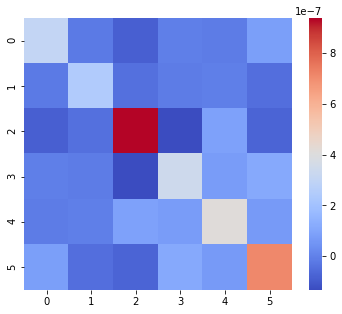

In [3]:
%%time

FREQS = [95.,150.]
NMAP = 2
RESAMP = 30
APOSCALE = 6.
PSBIN = 80

fullmap = dict()
fullmap[95] = map95[1:]
fullmap[150] = map150[1:]

fullvar = dict()
fullvar[95] = vmap95[1:]
fullvar[150] = vmap150[1:]

fullbeam = dict()
fullbeam[95] = fwhm[1]
fullbeam[150] = fwhm[2]

pipeline = af.tpfpipe(fullmap,mask=mask.reshape(1,-1),variances=fullvar,fwhms=fullbeam)
mock_cov = pipeline.preprocess_simple(aposcale=APOSCALE,psbin=PSBIN,nsamp=RESAMP)[1]

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(mock_cov,cmap='coolwarm',annot=False,ax=ax)

tmpmap = dict()
tmpmap[30] = map30f[1:]

s = syncmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN,
              templates=tmpmap,template_fwhms=None)
s.reset({'beta_s':-3.})

b = cambmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN)
b.reset({'r': 0.05})

print ('fg truths: ',s.params)
print ('cmb truths: ',b.params)

mock_bp = vec_simple(s.bandpower()+b.bandpower())


 template fitting kernel check list 

# of parameters
2
parameters
dict_keys(['r', 'beta_s'])
parameter range
{'r': [0.0, 0.1], 'beta_s': [-5.0, 0.0]}




iter: 1220 | +400 | bound: 0 | nc: 1 | ncall: 8611 | eff(%): 18.813 | loglstar:   -inf < -0.000 <    inf | logz: -1.969 +/-  0.058 | dlogz:  0.001 >  0.409                                           

CPU times: user 11.4 s, sys: 1.16 s, total: 12.6 s
Wall time: 12.4 s


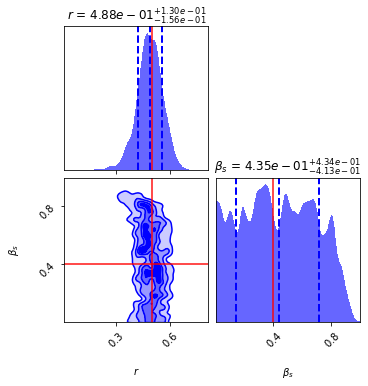

In [4]:
%%time

engine = tpfit_simple(mock_bp,mock_cov,b,s)

KWARGS = {'nlive':400}
result = engine(kwargs=KWARGS)

truths = [0.05/0.1,(5.-3.)/5.]
labels = [r'$r$',r'$\beta_s$']

fg, ax = dyplot.cornerplot(result, color='blue', truths=truths,
                           labels=labels, use_math_text=True,
                           truth_color='red', show_titles=True,title_fmt='.2e',
                           max_n_ticks=3, quantiles=[0.16,0.5,0.84])

### 2nd run with dust model

fg truths:  {'beta_d': 1.5}
cmb truths:  {'r': 0.05}
CPU times: user 11min 47s, sys: 4.4 s, total: 11min 51s
Wall time: 3min 10s


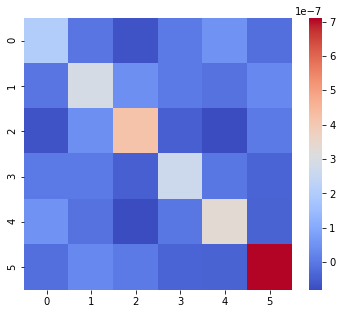

In [5]:
%%time

FREQS = [95.,150.]
NMAP = 2
RESAMP = 30
APOSCALE = 6.
PSBIN = 80

fullmap = dict()
fullmap[95] = map95[1:]
fullmap[150] = map150[1:]

fullvar = dict()
fullvar[95] = vmap95[1:]
fullvar[150] = vmap150[1:]

fullbeam = dict()
fullbeam[95] = fwhm[1]
fullbeam[150] = fwhm[2]

pipeline = af.tpfpipe(fullmap,mask=mask.reshape(1,-1),variances=fullvar,fwhms=fullbeam)
mock_cov = pipeline.preprocess_simple(aposcale=APOSCALE,psbin=PSBIN,nsamp=RESAMP)[1]

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(mock_cov,cmap='coolwarm',annot=False,ax=ax)

tmpmap = dict()
tmpmap[353] = map353f[1:]

d = dustmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN,
              templates=tmpmap,template_fwhms=None)
d.reset({'beta_d':1.5})

b = cambmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN)
b.reset({'r':0.05})
    
print ('fg truths: ',d.params)
print ('cmb truths: ',b.params)

mock_bp = vec_simple(d.bandpower()+b.bandpower())


 template fitting kernel check list 

# of parameters
2
parameters
dict_keys(['r', 'beta_d'])
parameter range
{'r': [0.0, 0.1], 'beta_d': [0.0, 5.0]}




iter: 3773 | +400 | bound: 8 | nc: 1 | ncall: 19355 | eff(%): 21.560 | loglstar:   -inf < -0.000 <    inf | logz: -8.379 +/-  0.192 | dlogz:  0.001 >  0.409                                          

CPU times: user 25.8 s, sys: 2.28 s, total: 28.1 s
Wall time: 26.5 s


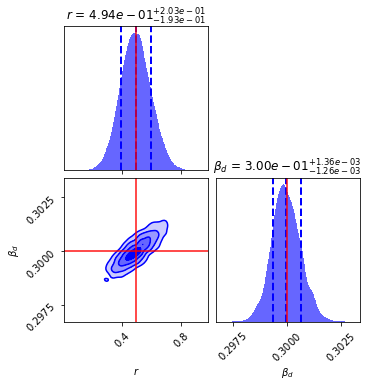

In [6]:
%%time

engine = tpfit_simple(mock_bp,mock_cov,b,d)

KWARGS = {'nlive':400}
result = engine(kwargs=KWARGS)

truths = [0.05/0.1,1.5/5.]
labels = [r'$r$',r'$\beta_d$']

fg, ax = dyplot.cornerplot(result, color='blue', truths=truths,
                           labels=labels, use_math_text=True,
                           truth_color='red', show_titles=True,title_fmt='.2e',
                           max_n_ticks=3, quantiles=[0.16,0.5,0.84])

### 3rd run with sync+dust model

fg truths:  {'beta_s': -3.0, 'beta_d': 1.5, 'rho': 0.1}
cmb truths:  {'r': 0.05}
CPU times: user 15min 27s, sys: 5.35 s, total: 15min 32s
Wall time: 4min 4s


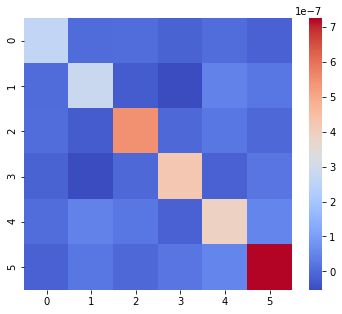

In [7]:
%%time

FREQS = [95.,150.]
NMAP = 2
RESAMP = 40
APOSCALE = 6.
PSBIN = 80

fullmap = dict()
fullmap[95] = map95[1:]
fullmap[150] = map150[1:]

fullvar = dict()
fullvar[95] = vmap95[1:]
fullvar[150] = vmap150[1:]

fullbeam = dict()
fullbeam[95] = fwhm[1]
fullbeam[150] = fwhm[2]

pipeline = af.tpfpipe(fullmap,mask=mask.reshape(1,-1),variances=fullvar,fwhms=fullbeam)
mock_cov = pipeline.preprocess_simple(aposcale=APOSCALE,psbin=PSBIN,nsamp=RESAMP)[1]

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(mock_cov,cmap='coolwarm',annot=False,ax=ax)

tmpmap = dict()
tmpmap[30] = map30f[1:]
tmpmap[353] = map353f[1:]

c = syncdustmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN,
                  templates=tmpmap,template_fwhms=None)
c.reset({'beta_s':-3.})
c.reset({'beta_d':1.5})
c.reset({'rho':0.1})

b = cambmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN)
b.reset({'r':0.05})
    
print ('fg truths: ',c.params)
print ('cmb truths: ',b.params)

mock_bp = vec_simple(c.bandpower()+b.bandpower())


 template fitting kernel check list 

# of parameters
4
parameters
dict_keys(['r', 'beta_s', 'beta_d', 'rho'])
parameter range
{'r': [0.0, 0.1], 'beta_s': [-5.0, 0.0], 'beta_d': [0.0, 5.0], 'rho': [-1.0, 1.0]}




iter: 3771 | +400 | bound: 13 | nc: 1 | ncall: 22411 | eff(%): 18.611 | loglstar:   -inf < -0.008 <    inf | logz: -8.397 +/-  0.192 | dlogz:  0.001 >  0.409                                         

CPU times: user 39.7 s, sys: 3.38 s, total: 43.1 s
Wall time: 39.4 s


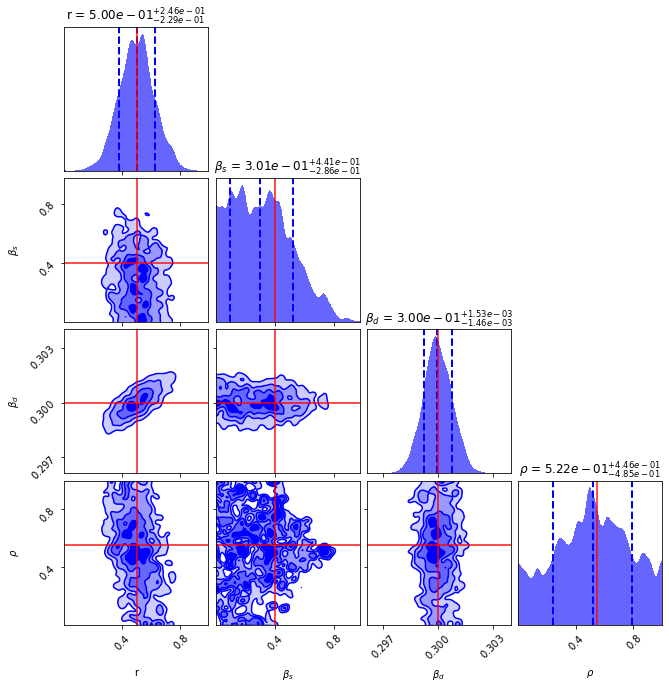

In [8]:
%%time

engine = tpfit_simple(mock_bp,mock_cov,b,c)

KWARGS = {'nlive':400}
result = engine(kwargs=KWARGS)

truths = [0.05/0.1,(5.-3.)/5.,1.5/5.,1.1/2.]
labels = [r'r',r'$\beta_s$',r'$\beta_d$',r'$\rho$']

fg, ax = dyplot.cornerplot(result, color='blue', truths=truths,
                           labels=labels, use_math_text=True,
                           truth_color='red', show_titles=True,title_fmt='.2e',
                           max_n_ticks=3, quantiles=[0.16,0.5,0.84])